## Disclaimer
In this whole project, we use color blind friendly graphical elements in order to minimise discrimination. 

In [223]:
# Data manipulation
import pandas as pd
import numpy as np
import scipy as stats

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Finance related operations
#from pandas_datareader import data (DNWFM)
 
# Import this to silence a warning when converting data column of a dataframe on the fly
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Train-Test Splitting
from sklearn.model_selection import train_test_split

#For Standardisation 
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.decomposition import PCA

#(to ignore warnings if needed)
#import warnings
#warnings.filterwarnings('ignore') 

sns.set()

%matplotlib inline

## 1. Load Data

We are loading the every csv file separately from the Data folder in the project directory. Once we have stored them in our Notebook we merge them together to form a larger dataframe containing all the information we have available.

In [224]:
df_2014 = pd.read_csv('Data/2014_Financial_Data.csv')
df_2014.rename(columns={df_2014.columns[0]:'Tickers'}, inplace=True)
df_2014 = pd.concat([pd.Series(df_2014['Tickers']).apply(lambda x: f'{x}-2014'), df_2014.iloc[:,1:]], axis=1)
df_2014.set_index('Tickers')

df_2015 = pd.read_csv('Data/2015_Financial_Data.csv')
df_2015.rename(columns={df_2015.columns[0]:'Tickers'}, inplace=True)
df_2015 = pd.concat([pd.Series(df_2015['Tickers']).apply(lambda x: f'{x}-2015'), df_2015.iloc[:,1:]], axis=1)
df_2015.set_index('Tickers')

df_2016 = pd.read_csv('Data/2016_Financial_Data.csv')
df_2016.rename(columns={df_2016.columns[0]:'Tickers'}, inplace=True)
df_2016 = pd.concat([pd.Series(df_2016['Tickers']).apply(lambda x: f'{x}-2016'), df_2016.iloc[:,1:]], axis=1)
df_2016.set_index('Tickers')

df_2017 = pd.read_csv('Data/2017_Financial_Data.csv')
df_2017.rename(columns={df_2017.columns[0]:'Tickers'}, inplace=True)
df_2017 = pd.concat([pd.Series(df_2017['Tickers']).apply(lambda x: f'{x}-2017'), df_2017.iloc[:,1:]], axis=1)
df_2017.set_index('Tickers')

df_2018 = pd.read_csv('Data/2018_Financial_Data.csv')
df_2018.rename(columns={df_2018.columns[0]:'Tickers'}, inplace=True)
df_2018 = pd.concat([pd.Series(df_2018['Tickers']).apply(lambda x: f'{x}-2018'), df_2018.iloc[:,1:]], axis=1)
df_2018.set_index('Tickers')


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
Tickers,,,,,,,,,,,,,,,,,,,,,
CMCSA-2018,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1
KMI-2018,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1
INTC-2018,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1
MU-2018,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1
GE-2018,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,-2.177200e+10,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YRIV-2018,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,3.755251e+06,3.755251e+06,-3.755251e+06,1.105849e+07,-1.482451e+07,...,0.0000,0.0000,-0.0508,-0.1409,-0.0152,0.0000,-0.2602,Real Estate,-90.962099,0
YTEN-2018,5.560000e+05,-0.4110,0.000000e+00,5.560000e+05,4.759000e+06,5.071000e+06,9.830000e+06,-9.274000e+06,0.000000e+00,-9.170000e+06,...,0.3445,0.0000,-0.2323,-0.8602,0.0000,0.0352,-0.0993,Basic Materials,-77.922077,0
ZKIN-2018,5.488438e+07,0.2210,3.659379e+07,1.829059e+07,1.652633e+06,7.020320e+06,8.672953e+06,9.617636e+06,1.239170e+06,8.416324e+06,...,0.1605,0.7706,0.2489,0.4074,-0.0968,0.2415,0.8987,Basic Materials,-17.834400,0


Now we add new YEAR column to each of the dataframes to later being able to group the rows by their year. We add them to an array, so we can iterate over them.

In [225]:
df_2014['year'] = '2014'
df_2015['year'] = '2015'
df_2016['year'] = '2016'
df_2017['year'] = '2017'
df_2018['year'] = '2018'

dataframes = [df_2014, df_2015, df_2016, df_2017, df_2018]

# 2. Merging of datasets

In [226]:
for df in dataframes:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 6.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4120 entries, 0 to 4119
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 7.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 8.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 8.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 7.6+ MB
None


We can see that the datasets are quite similar. The only thing that varies between them is the number of rows. As we want to append all the datasets to form a bigger dataset we expect 3808 + 4120 + 4797 + 4960 + 4392 = 22'077 rows in the generated dataset.

Looking at the column data types we have:
- 222 numeric (financial indicators)
- 1 integer (the **class** column)
- 2 objects (**Sector and Price Change** column)

In order to be able to append all the dataframes together we have to make sure all the columns have the same naming. It looks like the only column that is named differently from all the others across the datasets is the price change column. We are renaming it to 'PRICE CHANGE [%]'.


In [227]:
year = 2015
for df in dataframes:
    df.rename(columns = {f'{year} PRICE VAR [%]': 'PRICE CHANGE [%]'}, inplace=True)
    year += 1

To check our assumption and see if now all the columns really are the same we use the numpy array_equal function.

In [228]:
columns_2014 = df_2014.columns.values.tolist()
columns_2015 = df_2015.columns.values.tolist()
columns_2016 = df_2016.columns.values.tolist()
columns_2017 = df_2017.columns.values.tolist()
columns_2018 = df_2018.columns.values.tolist()

print(f'Columns in df 2014 and 2015 are equal: {np.array_equal(columns_2014, columns_2015)}')
print(f'Columns in df 2015 and 2016 are equal: {np.array_equal(columns_2015, columns_2016)}')
print(f'Columns in df 2016 and 2017 are equal: {np.array_equal(columns_2016, columns_2017)}')
print(f'Columns in df 2017 and 2018 are equal: {np.array_equal(columns_2017, columns_2018)}')

Columns in df 2014 and 2015 are equal: True
Columns in df 2015 and 2016 are equal: True
Columns in df 2016 and 2017 are equal: True
Columns in df 2017 and 2018 are equal: True


As we see that all computations output TRUE. By reflexivity we know that the columns of all the datasets now have the same values. Now we can start appending them to form the mega-dataset we want to start working with.

In [229]:
df = pd.concat(dataframes)


As expected we get a new dataframe with 22'077 entries and the common number of columns (225) of the individual datasets.

## Looking at data
We use a summary statistics to get a summary overview of our dataset before we work with it. 

In [230]:
df.describe()


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,PRICE CHANGE [%],Class
count,2.090600e+04,19989.000000,2.030600e+04,2.087000e+04,1.993900e+04,2.040800e+04,2.037500e+04,2.097600e+04,2.035800e+04,2.071300e+04,...,18264.000000,19952.000000,19650.000000,19690.000000,19213.000000,19462.000000,19598.000000,19655.000000,2.207700e+04,22077.000000
mean,5.161619e+09,3.622214,3.258565e+09,1.970452e+09,1.033333e+08,8.699279e+08,1.368670e+09,5.896979e+08,9.778939e+07,4.925003e+08,...,0.012298,10.978239,0.158858,1.134221,0.783208,3.733922,0.295610,0.365149,2.698893e+02,0.550754
std,3.197314e+10,312.648170,2.583092e+10,8.735750e+09,7.676062e+08,3.804283e+09,5.662984e+09,2.976454e+09,4.996543e+08,2.484345e+09,...,0.263079,1101.098165,3.268154,45.381079,66.524006,174.864701,12.974127,15.030054,1.934617e+04,0.497429
min,-6.276160e+08,-12.769300,-2.986888e+09,-1.280800e+10,-1.098000e+08,-1.401594e+08,-5.495512e+09,-1.933900e+10,-1.710954e+09,-2.177200e+10,...,-1.000000,-1.000000,-1.000000,-1.000000,-3963.131200,-1.051000,-2.662200,-2.369900,-1.003972e+02,0.000000
25%,5.880737e+07,-0.014700,3.211750e+06,3.035575e+07,0.000000e+00,1.768550e+07,3.564150e+07,-4.433750e+06,0.000000e+00,-8.745000e+06,...,0.000000,-0.051125,0.000000,-0.031075,-0.103800,-0.067475,0.000000,-0.013700,-1.947409e+01,0.000000
50%,4.352510e+08,0.057600,1.530115e+08,1.943525e+08,0.000000e+00,8.062450e+07,1.564000e+08,3.585350e+07,3.697000e+06,2.380000e+07,...,0.000000,0.009500,0.000000,0.048000,0.032400,0.000000,0.000000,0.061000,3.909087e+00,1.000000
75%,2.287259e+09,0.182400,1.180224e+09,8.806035e+08,1.220150e+07,3.699722e+08,6.210870e+08,2.554363e+08,4.969325e+07,1.964680e+08,...,0.040000,0.200550,0.058400,0.176800,0.142100,0.150075,0.000000,0.185350,2.750567e+01,1.000000
max,1.886894e+12,42138.663900,1.581527e+12,4.621600e+11,2.883700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,8.720500e+10,...,5.400500,153332.333300,293.473000,5468.426400,7039.325900,17646.823500,1542.611000,2042.000000,2.418601e+06,1.000000


We draw some boxplots to further get a grip on the data that we have. We draw them seperately as otherwise, the scale leads to misleading graphical results.

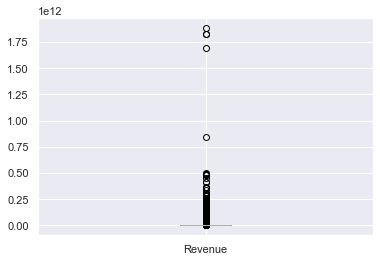

In [231]:
boxplot = df.boxplot(column=["Revenue"])  

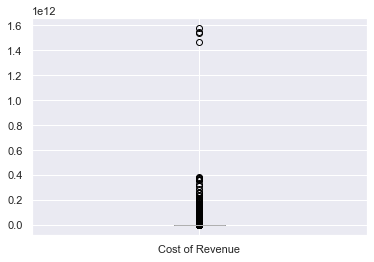

In [232]:
boxplot = df.boxplot(column=["Cost of Revenue"])  

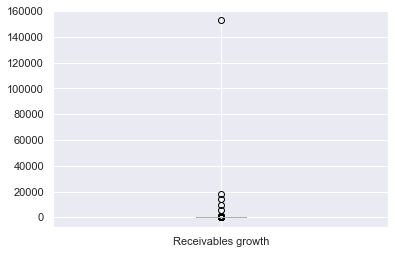

In [233]:
boxplot = df.boxplot(column=["Receivables growth"])

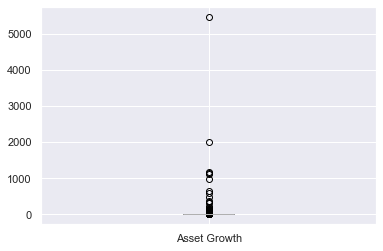

In [234]:
boxplot = df.boxplot(column=["Asset Growth"])

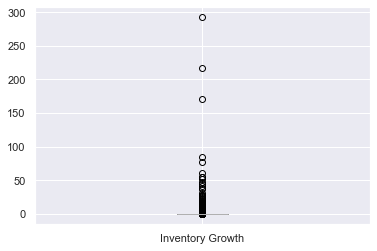

In [235]:
boxplot = df.boxplot(column=["Inventory Growth"])

We see that for the 5 columns that we chose to look at, the data is well distributed atound a centre, but there are some outliers, and as points might be below zero, this could indicate that there are potential missies filled as -1. Thus, in a next step, we will clean the data.

# 3. Splitting Data into Training, Test, and Validation Set

We begin by splitting our data into a training, test, and a validation set. The purpose of this is not to let any information of the test data set spill over onto our algorithm (e.g., when we fill the outliers with the mean of the whole dataset instead of the mean of the training dataset).

In [ ]:
#NOT READY
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8

X = df.drop(columns = ['SalePrice']).copy()
y = df['SalePrice']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

# 3. Start cleaning
Now that we have some information at one place we can start cleaning the dataset.

## NWY - Outliers
first, we do a stardisation of the data to then use a Principal Component Analysis to look at the variables in a multidimensional space and draw an ellipsis to check for any outliers


In [236]:

# Apply StandardScaler on continuous columns only
stdsc = StandardScaler()
# fit & transform
X_std = stdsc.fit_transform(df.select_dtypes(include='number'))

# Define no. of principal components
q = 10
# Create PCA object and fit to find # first q principal components
pca = PCA(n_components=q) 
pca.fit(X_std)
pca

# Run PCA for all possible PCs
pca = PCA().fit(X_std)
# Define max no. of PC
q = X_train_bal.shape[1]
# Get cumsum of the PC 1-q
expl_var = pca.explained_variance_ratio_ sum_expl_var = np.cumsum(expl_var)[:q]


SyntaxError: invalid syntax (2082225269.py, line 18)

## 3.1 Price Change outliers
As Price change is probably our most important feature we want to prepare that one first. This section is strongly inspired by an analysis done by Nicolas Carbone and can be found [HERE](https://www.kaggle.com/cnic92/explore-and-clean-financial-indicators-dataset)
We are looking for major peaks/valleys, which indicate stocks that increased/decreased in value by an incredible amount with respect to the overall sector.

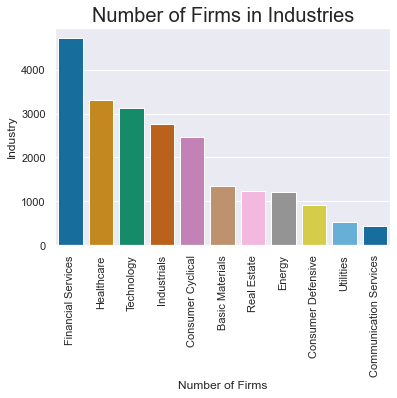

In [176]:
sectors = df['Sector'].unique().tolist()


df_sector = df['Sector'].value_counts()
sns.barplot(x=np.arange(len(df_sector)), y=df_sector, palette = 'colorblind')
plt.xticks(np.arange(len(df_sector)), df_sector.index.values.tolist(), rotation=90)
plt.xlabel("Number of Firms")
plt.ylabel("Industry")
plt.title('Number of Firms in Industries', fontsize=20)
plt.show()

As we see our dataset is unbalanced in regards to the sector count. This can lead to overfitting, but we will leave the data as is as it represents the true distribution of sectors in reality. Now let's take a look at a graphical representation of all the returns within a sector in the year 2019.

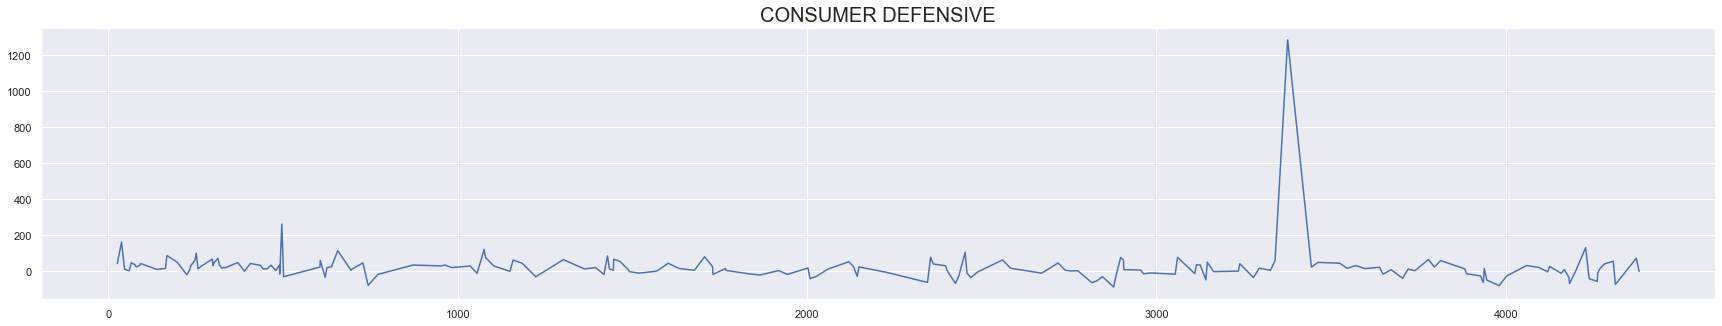

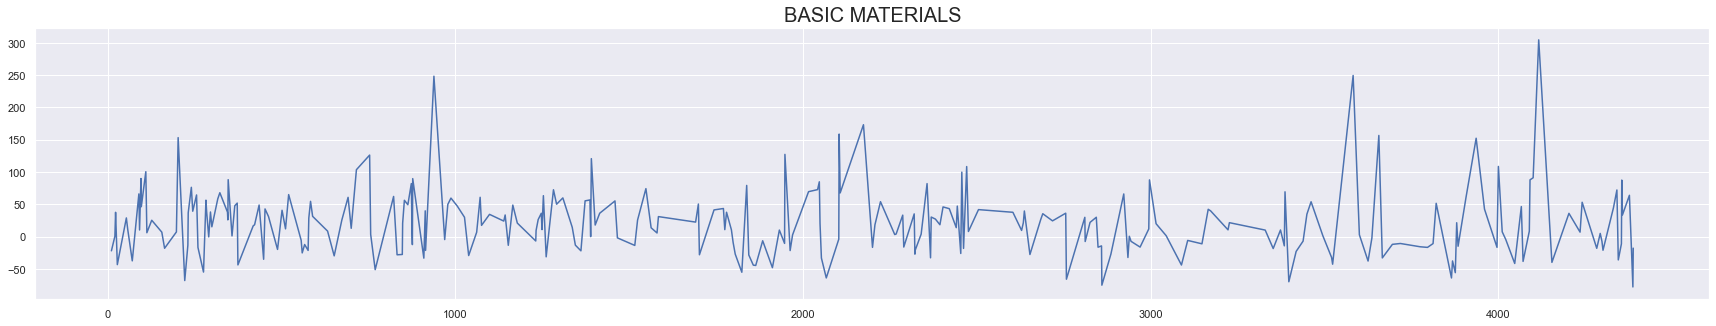

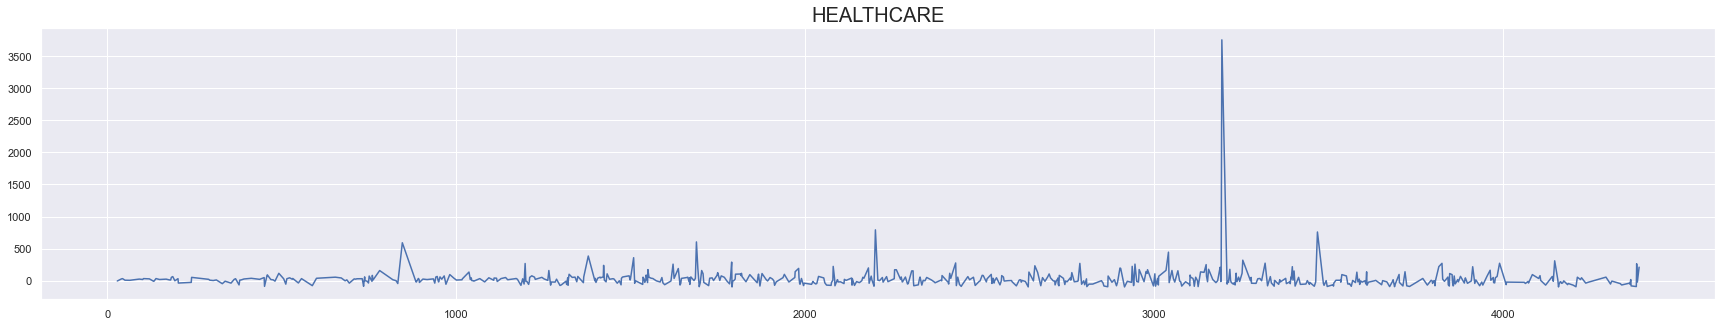

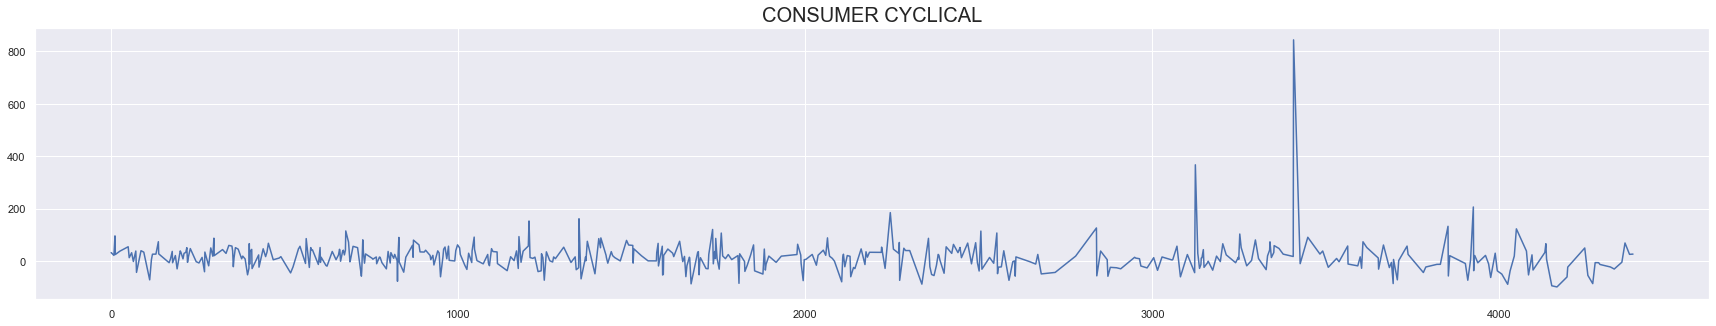

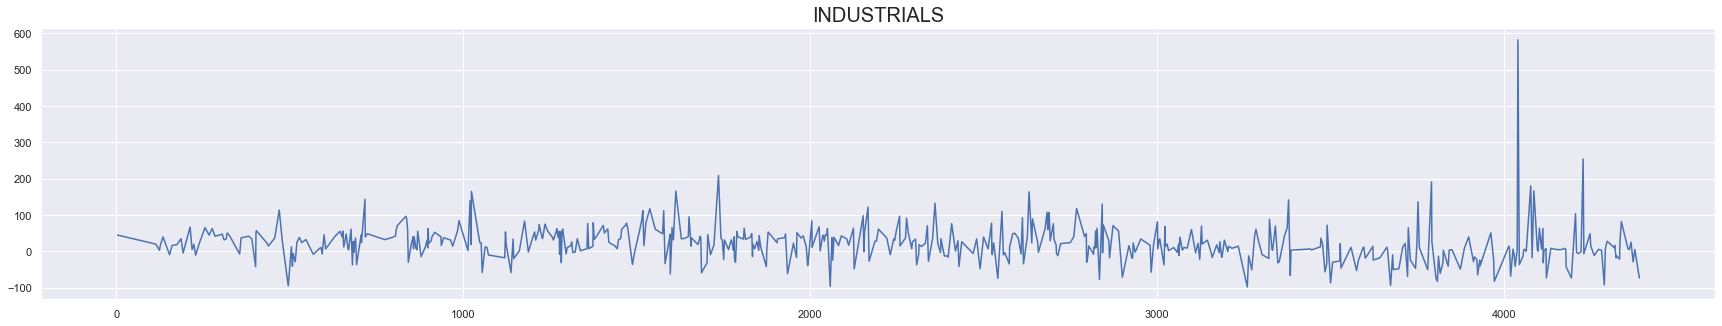

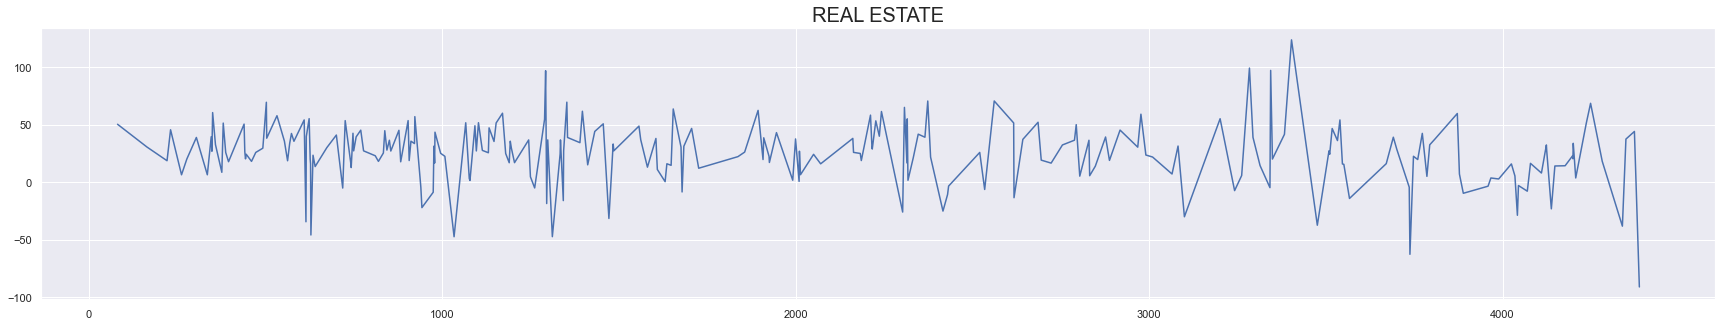

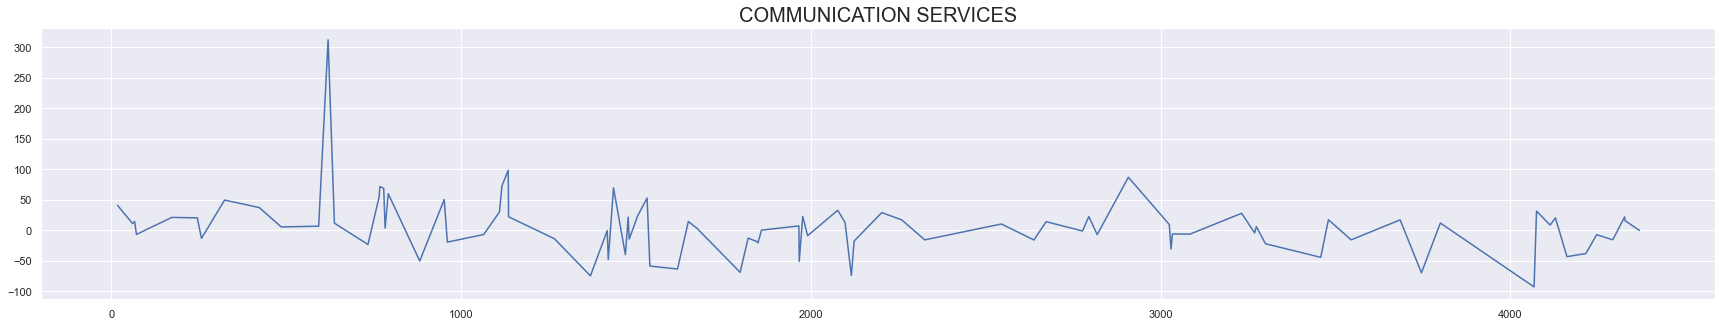

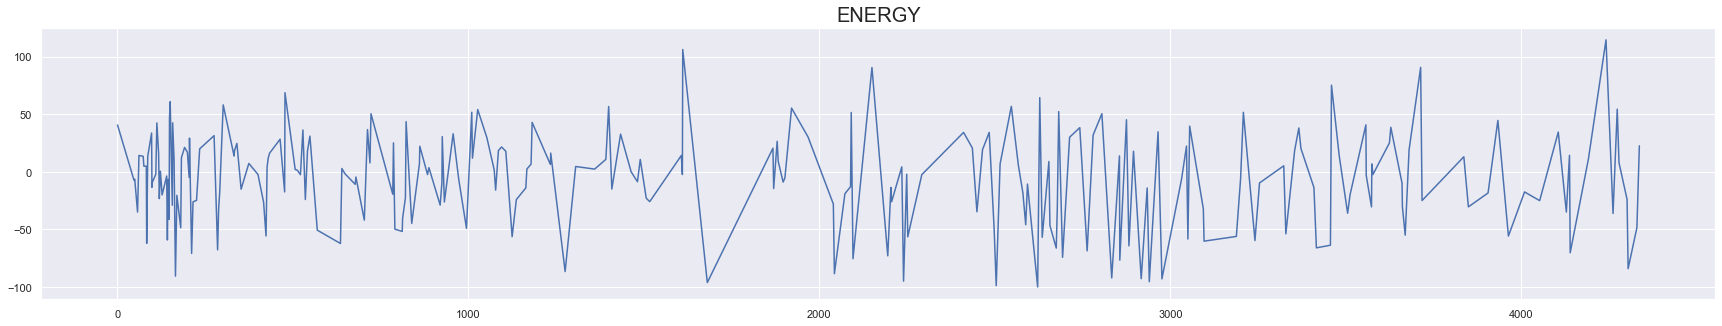

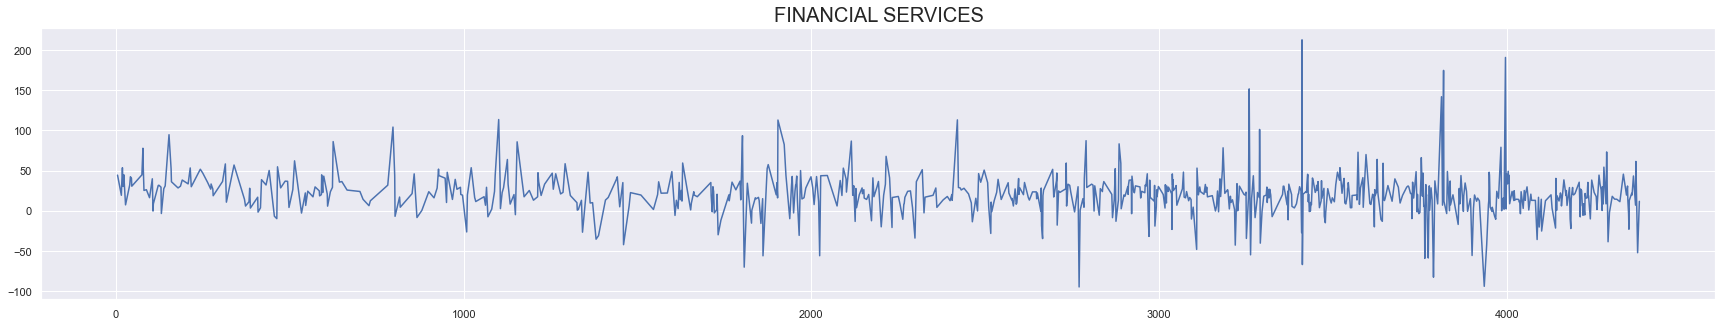

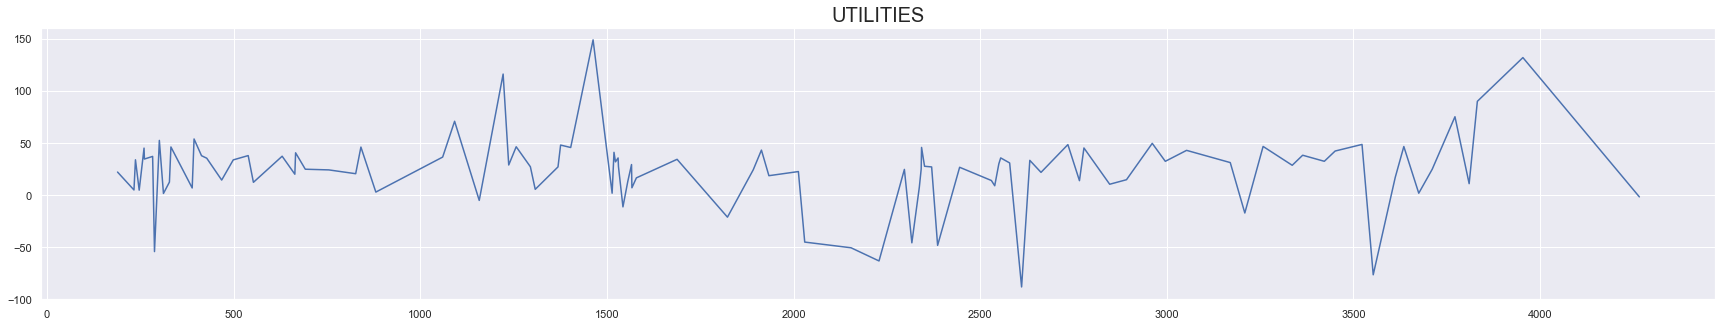

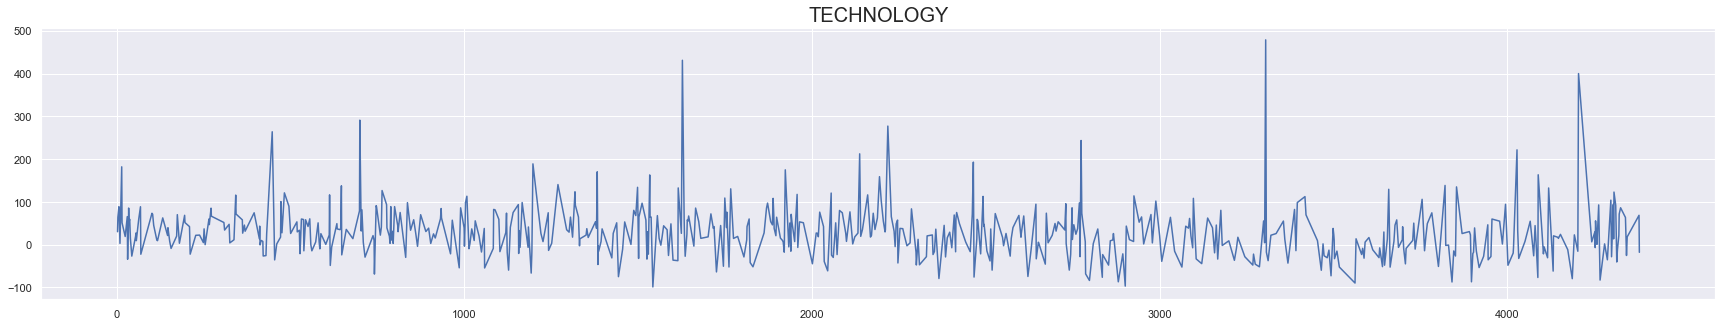

In [177]:
# Extract the columns we need in this step from the dataframe
df_ = df_2018.loc[:, ['Sector', 'PRICE CHANGE [%]']]

# Get list of sectors
sector_list = df_['Sector'].unique()

# Plot the percent price variation for each sector
for sector in sectors:

    temp = df_[df_['Sector'] == sector]

    plt.figure(figsize=(30,5))
    plt.plot(temp['PRICE CHANGE [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

As we see there is quite a number of peaks. We now want to dig a little deeper into that and examine wether those price changes could have been organic or inorganic growth. [Nicolas Carbone](https://www.kaggle.com/cnic92/explore-and-clean-financial-indicators-dataset) suggests to determine a threshhold, find all stocks that have performed better than the threshhold and get some financial data from Yahoo Finance for these specific stocks. More precisely we will compare the *Adjusted Daily Close Price* to the *Volume* and decide on that basis if it was organic or inorganic growth. We will do exactly that for every stock that had a performance greater that 500% in any year of our dataset.
Since the code for determining that in any year is mostly the same but only changes in some specific variables we will create a function that we will be able to reuse throughout the code.

In [178]:
def find_inorganic_stocks(df_, year, gain):
    inorganic_stocks = df_[df_['PRICE CHANGE [%]'] >= gain]
    top_gainers = inorganic_stocks[['Tickers','PRICE CHANGE [%]']].sort_values(by='PRICE CHANGE [%]', ascending=False)
    print(f'{len(inorganic_stocks)} STOCKS with more than {gain}% gain.')
    print()

    # Set
    date_start = f'01-01-{year}'
    date_end = f'12-31-{year}'
    #print(top_gainers)
    tickers = top_gainers['Tickers'].values.tolist()

    temp=[]

    for ticker in tickers:
        split_ticker = ticker.split('-')
        try:
            # Get daily prices for that stock from Yahoo finance
            daily_price = data.DataReader(split_ticker[0], 'yahoo', date_start, date_end)

            # Plot prices with volume
            fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

            ax0.plot(daily_price['Adj Close'])
            ax0.set_title(ticker, fontsize=18)
            ax0.set_ylabel('Daily Adj Close $', fontsize=14)
            ax1.plot(daily_price['Volume'])
            ax1.set_ylabel('Volume', fontsize=14)
            ax1.yaxis.set_major_formatter(
                    matplotlib.ticker.StrMethodFormatter('{x:.0E}'))

            fig.align_ylabels(ax1)
            fig.tight_layout()
            plt.show()

        except Exception as e:
            print(e)

    return tickers


### 3.1.1 Price Changes >500% in 2014

In [179]:
high_gainers_2014 = find_inorganic_stocks(df_2014, 2015, 500)

22 STOCKS with more than 500% gain.

name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined


Looking at these plots we have a lot of flat trading volume, very massive spikes and data that is not available for the entire year. For these cases we assume that these stocks did not grow organically. So we end up only taking *NYMX* and *AVXL* as organic growth. Therefore we exclude them from the high_gainers_2014 and drop those stocks then from the 2014 dataset.

In [180]:
high_gainers_2014.remove('NYMX-2014')
high_gainers_2014.remove('AVXL-2014')
df_2014=df_2014.set_index('Tickers')
df_2014.drop(high_gainers_2014, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2015

In [181]:
high_gainers_2015 = find_inorganic_stocks(df_2015, 2016, 500)
print(high_gainers_2015)

10 STOCKS with more than 500% gain.

name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
['ARA-2015', 'LN-2015', 'ARCH-2015', 'NTB-2015', 'TELL-2015', 'WINS-2015', 'NBEV-2015', 'GLBS-2015', 'NAK-2015', 'VST-2015']


In [182]:
# we are keeping  NAK and NBEV
high_gainers_2015.remove('NAK-2015')
high_gainers_2015.remove('NBEV-2015')
df_2015=df_2015.set_index('Tickers')
df_2015.drop(high_gainers_2015, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2016

In [183]:
high_gainers_2016 = find_inorganic_stocks(df_2016, 2017, 500)

19 STOCKS with more than 500% gain.

name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined


In [184]:
# we are keeping  HlG and GRVY
high_gainers_2016.remove('HLG-2016')
high_gainers_2016.remove('GRVY-2016')
df_2016=df_2016.set_index('Tickers')
df_2016.drop(high_gainers_2016, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2017

In [185]:
high_gainers_2017 = find_inorganic_stocks(df_2017, 2018, 500)

5 STOCKS with more than 500% gain.

name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined


In [186]:
# we are keeping  HEAR and TNDM
high_gainers_2017.remove('HEAR-2017')
high_gainers_2017.remove('TNDM-2017')
df_2017=df_2017.set_index('Tickers')
df_2017.drop(high_gainers_2017, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2018

In [187]:
high_gainers_2018 = find_inorganic_stocks(df_2018, 2019, 500)

8 STOCKS with more than 500% gain.

name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined
name 'data' is not defined


In [188]:
# we are keeping  ALIM
high_gainers_2018.remove('ALIM-2018')
df_2018=df_2018.set_index('Tickers')
df_2018.drop(high_gainers_2018, axis=0, inplace=True)

# 4. Missing values and 0-values

Our dataset contains lots of 0 and missing values. In this chapter we will discuss our approach to remove/replace them. First of all we create a larger dataset by appending all the separate datasets onto each other. Then we will take a closer look at the missing and 0 values and decide how many are allowed to miss in a column in order to keep the column. After that we will get rid of those columns and replace the missing values that are left with an appropriate dummy variable.

To determine the extent of the missies that our dataset has, we display the missing data. We then drop all the columns with more than 20% missies. 
Further, there are some ways to deal with the remaining missies. As some ML algorithms are sensitive to missies, we choose to fill the missies with 0 because there is no value for that year. Another common way to deal with missies would have been to replace them by the average value, the mode or the mean of the column. We decide not to do that as this requires a thorough analysis by means of a boxplot of each of the columns in order to check whether the data of the respective column is skewed or not. 

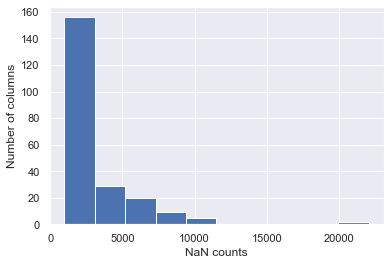

In [191]:
nan_counts=df.isnull().sum()
nan_counts[nan_counts>0]
numeric_cols=df.select_dtypes(include=['float64','int64']).columns
df[numeric_cols].isnull().sum().sort_values(ascending=False)

#Histogram for the NaN counts
marks=np.array(nan_counts[nan_counts>0])
fig,ax=plt.subplots(1,1)
ax.hist(marks)
ax.set_xlabel('NaN counts')
ax.set_ylabel('Number of columns')
plt.show()

In [192]:
df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(df_info)

,Tickers,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE CHANGE [%],Class,year
column type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,object,float64,int64,object
null values (nb),0,1171,2088,1771,1207,2138,1669,1702,1101,1719,...,2427,2387,2864,2615,2479,2422,0,0,0,0
null values (%),0.0,5.304163,9.457807,8.021923,5.467228,9.684287,7.559904,7.709381,4.987091,7.786384,...,10.993341,10.812157,12.972777,11.844906,11.228881,10.970693,0.0,0.0,0.0,0.0


We drop all the columns containing more than 20% NaN values

In [193]:
percent_nan = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
df.drop(percent_nan[percent_nan.values > 20].index.tolist(),axis='columns', inplace=True)

df_info_ar=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
df_info_ar=df_info_ar.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
df_info_ar=df_info_ar.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(df_info_ar)


,Tickers,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE CHANGE [%],Class,year
column type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,object,float64,int64,object
null values (nb),0,1171,2088,1771,1207,2138,1669,1702,1101,1719,...,2427,2387,2864,2615,2479,2422,0,0,0,0
null values (%),0.0,5.304163,9.457807,8.021923,5.467228,9.684287,7.559904,7.709381,4.987091,7.786384,...,10.993341,10.812157,12.972777,11.844906,11.228881,10.970693,0.0,0.0,0.0,0.0


We look at the 0 values in the different columns. We decide to drop all the columns containing more than 30% 0 values as there is still a chance that the value 0 contains information (e.g., no dividends paid -> 0)

In [194]:
df_info_null=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
df_info_null=df_info_null.append(pd.DataFrame((df == 0).sum()).T.rename(index={0:'zero values (nb)'}))
df_info_null=df_info_null.append(pd.DataFrame((df == 0).sum()/df.shape[0]*100).T.
                         rename(index={0:'zero values (%)'}))
display(df_info_null)


,Tickers,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE CHANGE [%],Class,year
column type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,object,float64,int64,object
zero values (nb),0,937,991,4346,934,12556,499,81,32,5193,...,9066,37,29,3704,12419,497,0,25,9918,0
zero values (%),0.0,4.244236,4.488835,19.685646,4.230647,56.873669,2.260271,0.366898,0.144947,23.522218,...,41.065362,0.167595,0.131358,16.777642,56.253114,2.251212,0.0,0.11324,44.924582,0.0


In [196]:
null_counts=(df == 0).sum()
null_counts[null_counts>0]
numeric_cols=df.select_dtypes(include=['float64','int64']).columns
(df == 0).sum().sort_values(ascending=False)

Preferred Dividends                 17458
Net Income - Discontinued ops       17361
Deposit Liabilities                 16665
Net Income - Non-Controlling int    13308
R&D to Revenue                      13308
                                    ...  
Sector                                  0
Tickers                                 0
companyEquityMultiplier                 0
operatingProfitMargin                   0
year                                    0
Length: 174, dtype: int64

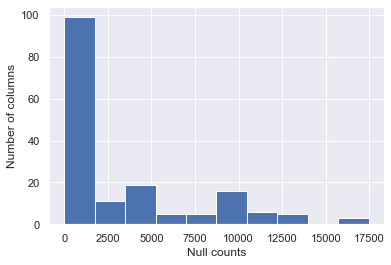

In [195]:
null_counts=(df == 0).sum()
null_counts[null_counts>0]
numeric_cols=df.select_dtypes(include=['float64','int64']).columns
(df == 0).sum().sort_values(ascending=False)

#Histogramm for the Null counts
marks=np.array(null_counts[null_counts>0])
fig,ax=plt.subplots(1,1)
ax.hist(marks)
ax.set_xlabel('Null counts')
ax.set_ylabel('Number of columns')
plt.show()

Here, we find evidence supporting our hypothesis, that the value 0 can contain actual information, as there are substantially less columns containing less than 10% of 0. This underlines that it makes more sense to set the border higher than for the NaN-values. 

In [197]:
percent_null = ((df == 0).sum()/df.shape[0]*100).sort_values(ascending=False)
df.drop(percent_null[percent_null.values > 30].index.tolist(),axis='columns', inplace=True)

df_info_null_ar=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
df_info_null_ar=df_info_null_ar.append(pd.DataFrame((df == 0).sum()).T.rename(index={0:'null values (nb)'}))
df_info_null_ar=df_info_null_ar.append(pd.DataFrame((df == 0).sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(df_info_null_ar)

,Tickers,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Operating Cash Flow growth,Free Cash Flow growth,Receivables growth,Asset Growth,Book Value per Share Growth,Debt Growth,SG&A Expenses Growth,Sector,PRICE CHANGE [%],year
column type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,object,float64,object
null values (nb),0,937,991,4346,934,499,81,32,5193,27,...,62,18,3302,37,29,3704,497,0,25,0
null values (%),0.0,4.244236,4.488835,19.685646,4.230647,2.260271,0.366898,0.144947,23.522218,0.122299,...,0.280835,0.081533,14.956742,0.167595,0.131358,16.777642,2.251212,0.0,0.11324,0.0


We are now left with 137 columns. We will in a later step (X.x) fill these values with the mean of the respective column. However, we will therefore first split the data set into a training and a test set to prevent any information spilling over.

## NO - we can miss too much valuable data (esp. when we have skewed data)
Since outliers pollute our dataset we will go ahead dropping top and bottom 5%

In [380]:
#NO
top_quantiles = df.quantile(0.95)
outliers_top = (df > top_quantiles)

low_quantiles = df.quantile(0.05)
outliers_low = (df < low_quantiles)

df = df.mask(outliers_top, top_quantiles, axis=1)
df = df.mask(outliers_low, low_quantiles, axis=1)

/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/2162141620.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_top = (df > top_quantiles)
/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/2162141620.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_low = (df < low_quantiles)


# Handling Outliers


In [ ]:
We use the Mahalonobis D on the dataset to detect outliers in a multivariate space

In [246]:
prov_df = df.select_dtypes(include =['float64'])
prov_df=prov_df.dropna(axis='columns')
print(prov_df)
prov_df=prov_df.to_numpy()
print(prov_df)

      PRICE CHANGE [%]
0            -9.323276
1           -25.512193
2            33.118297
3             2.752291
4            12.897715
...                ...
4387        -90.962099
4388        -77.922077
4389        -17.834400
4390        -73.520000
4391        209.462222

[22077 rows x 1 columns]
[[ -9.323276  ]
 [-25.51219289]
 [ 33.11829672]
 ...
 [-17.83440008]
 [-73.51999998]
 [209.4622218 ]]


In [222]:
def mahalanobis(x=None, data=None, cov=None):

    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

#create new column in dataframe that contains Mahalanobis distance for each row
prov_df['mahalanobis'] = mahalanobis(x=prov_df, data=prov_df[[,0:134]])

#display first five rows of dataframe
prov_df.head()


SyntaxError: invalid syntax (3277924798.py, line 12)

# 6. Fill Inappropriate values reasonably

We will be filling the missing values with the sector mean of a given year. But before thatwe will split our dataset into a train and a test set to prevent information from the training set to leak into the test set.

In [381]:
df.replace(0, np.nan, inplace=True)
# Replace nan-values with mean value of column, considering each sector individually.
df.info()

sectors = df
# df_no_sector= df.groupby(['Sector', 'year']).transform(lambda x: x.fillna(x.mean()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 0 to 4391
Columns: 128 entries, Tickers to year
dtypes: float64(125), object(3)
memory usage: 21.7+ MB


In [382]:
#percent_nan = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
#percent_zero = (df.isin([0]).sum()/df.shape[0]*100).sort_values(ascending=False)

In [383]:
#percent_zero

In [439]:
sp500 = pd.read_csv('Data/sp500.csv')
sp500 = sp500[-9:-3]
sp500['year'] = sp500['date'].apply(lambda x: x.split('-')[0])
#sp500 = sp500[sp500.columns[-2:]]
sp500.set_index('date')

,value,year
date,,
2014-12-31,11.39,2014
2015-12-31,-0.73,2015
2016-12-30,9.54,2016
2017-12-29,19.42,2017
2018-12-31,-6.24,2018
2019-12-31,28.88,2019


In [440]:
sp_df = pd.merge(left=df,right=sp500, left_on='year', right_on='year').set_index('Tickers')
sp_df.rename(columns={sp_df.columns[-1]: 'sp500-return'}, inplace=True)
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22077 entries, PG-2014 to ZYME-2018
Columns: 129 entries, Revenue to sp500-return
dtypes: float64(126), object(3)
memory usage: 21.9+ MB


In order to make the train/test split in the next step we must define the response column, we name it 'Investment Advice', first:
- if 'PRICE CHANGE [%]' - 'sp500-return' > 2.5 => 1 [BUY]
- if 'PRICE CHANGE [%]' - 'sp500-return' < 2.5  and 'PRICE CHANGE [%] - 'sp500-return' > -2.5 => 0 [HOLD]
- if 'PRICE CHANGE [%]' - 'sp500-return' < -2.5 => -1 [SELL]

In [442]:
def create_response(row):
    diff = row[0] - row[1]
    if diff > 2.5:
        return 1
    elif diff < -2.5:
        return -1

    return 0

In [444]:
response = sp_df[['PRICE CHANGE [%]', 'sp500-return']]
response['Investment Advice'] = response.apply(create_response, axis=1)
response = response['Investment Advice']
response

/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/907635918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response['Investment Advice'] = response.apply(create_response, axis=1)


Tickers
PG-2014     -1
VIPS-2014   -1
KR-2014      1
RAD-2014    -1
GIS-2014     0
            ..
YRIV-2018   -1
YTEN-2018   -1
ZKIN-2018   -1
ZOM-2018    -1
ZYME-2018    1
Name: Investment Advice, Length: 22077, dtype: int64

In [469]:
x_train, x_test, y_train, y_test = train_test_split(sp_df,response,test_size=0.1, random_state=21)

Now that we have a train and a test set we will replace all missing values with a reasonable variable. For now we have decided to go with the sector mean.

In [470]:
x_train.info()
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19869 entries, RJF-2015 to VZ-2017
Columns: 129 entries, Revenue to sp500-return
dtypes: float64(126), object(3)
memory usage: 19.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 2208 entries, GMRE-2018 to IMMP-2016
Columns: 129 entries, Revenue to sp500-return
dtypes: float64(126), object(3)
memory usage: 2.2+ MB


In [471]:
# store Sectors df since we will need it later but lose it during calculation of the mean
sectors_df = x_train['Sector']
x_train_ = x_train.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))
x_train = pd.concat([x_train_, sectors_df], axis=1)
x_train

/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/1324228833.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  x_train_ = x_train.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Income Tax Expense,Net Income,...,Free Cash Flow growth,Receivables growth,Asset Growth,Book Value per Share Growth,Debt Growth,SG&A Expenses Growth,PRICE CHANGE [%],year,sp500-return,Sector
Tickers,,,,,,,,,,,,,,,,,,,,,
RJF-2015,5.203606e+09,0.07040,1.023170e+08,5.101289e+09,3.573876e+09,4.286677e+09,8.146120e+08,7.981740e+08,2.960340e+08,5.021400e+08,...,0.842900,0.021600,0.134700,0.071900,0.030500,0.06390,24.815454,2015,-0.73,Financial Services
BBBY-2014,1.150396e+10,0.05400,6.938381e+09,4.565582e+09,2.950995e+09,2.950995e+09,1.614587e+09,1.613447e+09,5.911570e+08,1.022290e+09,...,0.205200,0.115615,0.012100,0.029800,0.133462,0.07290,-37.117168,2014,11.39,Consumer Cyclical
EIGI-2016,1.111142e+09,0.49890,5.839910e+08,5.271510e+08,4.466060e+08,5.664910e+08,-3.934000e+07,-1.410360e+08,-3.031380e+07,-7.283100e+07,...,-0.193700,0.087000,0.529100,-0.318700,0.803900,0.78378,7.692300,2016,9.54,Technology
MFC-2018,2.040475e+10,-0.31904,1.165087e+10,7.850082e+09,3.573876e+09,5.367974e+09,2.723871e+09,2.382800e+09,4.681481e+08,1.914130e+09,...,0.017000,0.124500,-0.030200,0.053400,-0.065100,0.03740,47.832096,2018,-6.24,Financial Services
DISCA-2018,1.055300e+10,0.53540,3.935000e+09,6.618000e+09,2.620000e+09,4.768000e+09,1.850000e+09,9.350000e+08,3.410000e+08,5.940000e+08,...,0.625800,0.425500,0.443100,0.402700,0.135800,0.48190,26.751846,2018,-6.24,Consumer Cyclical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC-2017,2.691500e+07,-0.13810,7.130000e+05,2.620200e+07,3.652300e+07,4.658800e+07,-2.038600e+07,6.417000e+06,-2.420000e+06,8.837000e+06,...,-3.303310,1.237935,0.057000,0.098100,-0.426000,0.17940,3.719716,2017,19.42,Financial Services
BDXA-2016,1.248300e+10,0.19238,6.492000e+09,5.991000e+09,3.005000e+09,4.561000e+09,1.430000e+09,1.074000e+09,9.700000e+07,9.760000e+08,...,-0.205443,0.210516,0.259885,0.083106,0.114911,0.23633,13.835859,2016,9.54,Healthcare
CUZ-2015,2.043690e+08,0.15100,8.254500e+07,1.218240e+08,2.034800e+07,9.345300e+07,2.837100e+07,1.255180e+08,1.127297e+07,1.255180e+08,...,1.600900,0.137100,-0.027000,-0.048200,-0.092800,-0.13180,29.678787,2015,-0.73,Real Estate


Now let's do the same for the test dataframe

In [472]:
sectors_df = x_test['Sector']
x_test_ = x_test.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))
x_test = pd.concat([x_test_, sectors_df], axis=1)
x_test

/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/1635177680.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  x_test_ = x_test.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Income Tax Expense,Net Income,...,Free Cash Flow growth,Receivables growth,Asset Growth,Book Value per Share Growth,Debt Growth,SG&A Expenses Growth,PRICE CHANGE [%],year,sp500-return,Sector
Tickers,,,,,,,,,,,,,,,,,,,,,
GMRE-2018,5.319200e+07,0.753000,7.895670e+08,5.319200e+07,5.537000e+06,3.133100e+07,2.186100e+07,1.349000e+07,2.076219e+07,1.349000e+07,...,0.472300,1.237935,0.348200,-0.023900,0.569600,0.008700,59.088404,2018,-6.24,Real Estate
POWL-2016,5.652430e+08,-0.146000,4.590380e+08,1.062050e+08,7.492400e+07,9.044800e+07,1.575700e+07,1.779300e+07,2.283000e+06,1.551000e+07,...,3.821400,-0.199900,-0.013500,0.047600,-0.142900,-0.024400,-24.964503,2016,9.54,Industrials
CBRE-2017,1.862879e+10,0.072500,1.165087e+10,4.323688e+09,2.858720e+09,3.264834e+09,1.058854e+09,1.164866e+09,4.677570e+08,6.971090e+08,...,0.092768,0.040900,0.066600,0.357000,0.194221,0.028000,-8.626195,2017,19.42,Real Estate
SPGI-2014,5.051000e+09,0.074200,1.651000e+09,3.400000e+09,3.144000e+09,3.278000e+09,1.220000e+08,1.300000e+08,2.450000e+08,-1.150000e+08,...,1.615200,-0.017900,0.117500,-0.620900,-0.005000,0.783780,12.653795,2014,11.39,Industrials
SWCH-2017,3.782750e+08,0.188200,1.982300e+08,1.800450e+08,1.605690e+08,1.612180e+08,1.882700e+07,-1.618900e+07,-9.810000e+05,-1.520800e+07,...,-1.126600,0.794500,0.557800,1.163880,0.233000,0.783780,-58.985391,2017,19.42,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CRVL-2016,5.035840e+08,0.022200,3.990400e+08,1.045440e+08,5.848400e+07,5.848400e+07,4.606000e+07,4.606000e+07,1.753500e+07,2.852500e+07,...,0.611100,0.038400,0.041100,0.075300,0.157088,0.075000,41.823063,2016,9.54,Financial Services
BJZ-2018,5.200000e+07,0.114084,3.400000e+07,1.900000e+07,1.300000e+07,1.200000e+07,6.000000e+06,6.000000e+06,1.000000e+06,6.000000e+06,...,0.178875,0.119124,0.093006,0.056818,0.157088,0.093216,9.281131,2018,-6.24,Financial Services
ASH-2016,3.019000e+09,-0.117300,2.132000e+09,8.870000e+08,8.580000e+08,9.450000e+08,-5.800000e+07,-5.400000e+07,-2.500000e+07,-2.900000e+07,...,2.938600,-0.364600,-0.005400,0.200100,-0.330900,0.239900,35.617212,2016,9.54,Basic Materials
